# Import

In [1]:
import pandas as pd
import numpy as np
import glob
import os
from datetime import datetime as dt
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from scikeras.wrappers import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, log_loss
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
import joblib
from sklearn.model_selection import train_test_split
from datetime import timedelta
from collections import Counter
import glob


# About Dataset
- Sample Rate = 125Hz
- Duration = 1200 seconds (20 mins)
- AF = 19 patients (mimic_perform_af_001 to mimic_perform_af_019)
- Non-AF = 16 patients (mimic_perform_non_af_001 to mimic_perform_non_af_016)
- n_data per patient = 150,000 (after removing row 150,001)
- Data source: Separate folders for AF and non-AF patients

## Path

In [2]:
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir))
af_folder = os.path.join(project_root, 'Data', 'af')
nonaf_folder = os.path.join(project_root, 'Data', 'non-af')

af_files = sorted(glob.glob(os.path.join(af_folder, '*.csv')))[:19]
nonaf_files = sorted(glob.glob(os.path.join(nonaf_folder, '*.csv')))[:16]

## Train Test Split

In [3]:
test_af = af_files[-3:]        
val_af = af_files[-6:-3]       
train_af = af_files[:-6]       

test_nonaf = nonaf_files[-3:]  
val_nonaf = nonaf_files[-6:-3] 
train_nonaf = nonaf_files[:-6]

## Load Dataset

In [4]:
def load(files, status):
    arr = []
    for f in files:
        df = pd.read_csv(f)
        if len(df) > 150000:
            df = df.iloc[:150000]
        df['status'] = status
        arr.append(df)
    return arr

test_af_data = load(test_af, 1)
val_af_data = load(val_af, 1)
train_af_data = load(train_af, 1)

test_nonaf_data = load(test_nonaf, 0)
val_nonaf_data = load(val_nonaf, 0)
train_nonaf_data = load(train_nonaf, 0)

test = pd.concat(test_af_data + test_nonaf_data, ignore_index=True)
val = pd.concat(val_af_data + val_nonaf_data, ignore_index=True)
train = pd.concat(train_af_data + train_nonaf_data, ignore_index=True)
df = pd.concat([train, val, test], ignore_index=True)
df

,Time,PPG,ECG,resp,status
0,0.000,0.537634,0.425781,-0.029340,1
1,0.008,0.534702,0.404297,-0.036675,1
2,0.016,0.531769,0.400391,-0.044010,1
3,0.024,0.528837,0.400391,-0.053790,1
4,0.032,0.524927,0.419922,-0.061125,1
...,...,...,...,...,...
5249995,1199.960,2.270772,0.325024,0.018447,0
5249996,1199.968,2.266862,0.339687,0.024272,0
5249997,1199.976,2.259042,0.365103,0.030097,0
5249998,1199.984,2.248289,0.374878,0.035437,0


# EDA

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3450000 entries, 0 to 3449999
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Time    float64
 1   PPG     float64
 2   ECG     float64
 3   resp    float64
 4   status  int64  
dtypes: float64(4), int64(1)
memory usage: 131.6 MB


In [6]:
train.describe()

,Time,PPG,ECG,resp,status
count,3.450000e+06,3.448829e+06,3.449864e+06,2.700000e+06,3.450000e+06
mean,5.999960e+02,8.911913e-01,4.143253e-01,2.379045e-01,5.652174e-01
std,3.464102e+02,7.118737e-01,3.080990e-01,4.993790e-01,4.957285e-01
min,0.000000e+00,0.000000e+00,-5.019608e-01,-1.846506e+00,0.000000e+00
25%,2.999980e+02,3.921569e-01,2.346041e-01,7.903780e-02,0.000000e+00
50%,5.999960e+02,5.307918e-01,4.150391e-01,2.508591e-01,1.000000e+00
75%,8.999940e+02,1.527859e+00,5.826772e-01,5.014663e-01,1.000000e+00
max,1.199992e+03,4.001955e+00,1.503937e+00,2.844215e+00,1.000000e+00


In [7]:
status_count = train['status'].value_counts()
status_count

status
1    1950000
0    1500000
Name: count, dtype: int64

## Pie chart AF Status

In [8]:
# Pie chart (for percentage)
status = status_count.sort_index()
status_index = status.index
fig = px.pie(names=status_index, values=status, hole=0.3,
             labels={'names':'status'}, title='AF Status Distribution Pie Chart')
fig.update_traces(textposition='inside', textinfo='percent+label+value')
fig.show()


In [9]:
train.isna().sum()

Time           0
PPG         1171
ECG          136
resp      750000
status         0
dtype: int64

In [10]:
train.isna().mean() * 100

Time       0.000000
PPG        0.033942
ECG        0.003942
resp      21.739130
status     0.000000
dtype: float64

## Visualize signal on specific range

In [11]:
def show_wave_from(df, pasien_ke=1, s_start=0, s_stop=10, fitur='ppg', af_status=0, sample_rate=125):
    lama_ukur = 1200 # 20m = 1200s
    sample_per_pasien = lama_ukur * sample_rate
    duration = s_stop - s_start

    if 0 <= s_start <= lama_ukur and 0 <= s_stop <= lama_ukur:
        if af_status == 0 and 1 <= pasien_ke <= 16:
            afdf = df[df['status'] == 0]
        elif af_status == 1 and 1 <= pasien_ke <= 19:
            afdf = df[df['status'] == 1]
        else:
            print('Invalid nomor pasien atau sample time')

        dfpasien = afdf[(pasien_ke - 1) * sample_per_pasien : pasien_ke * sample_per_pasien]
        dfintvl = dfpasien[sample_rate*s_start : (sample_rate*s_stop)+1]
            
        x_ax = dfintvl['Time']
        y_ax = dfintvl[fitur]

        plt.figure(figsize=(16, 4))
        plt.plot(x_ax, y_ax)
        plt.title(f'Gelombang {fitur} dari pasien ke-{pasien_ke} dari {s_start} - {s_stop} detik')

        step = s_start
        for t in range(duration):
            step += 1
            plt.axvline(x=step, color='gray', linestyle='--', linewidth=0.8)

        plt.show()

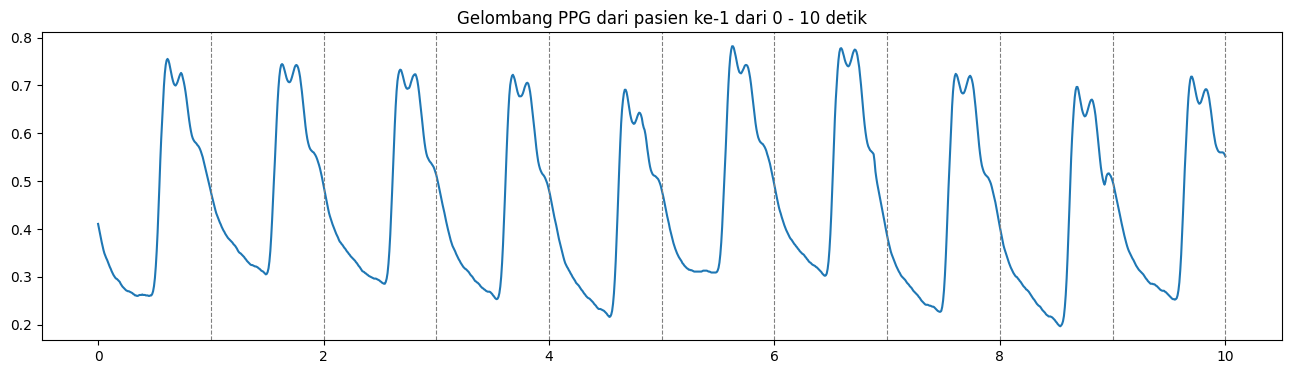

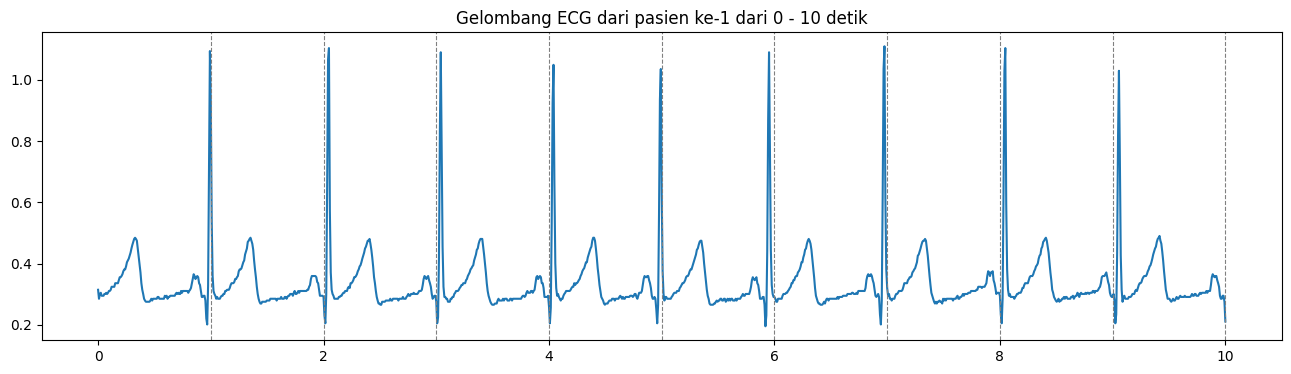

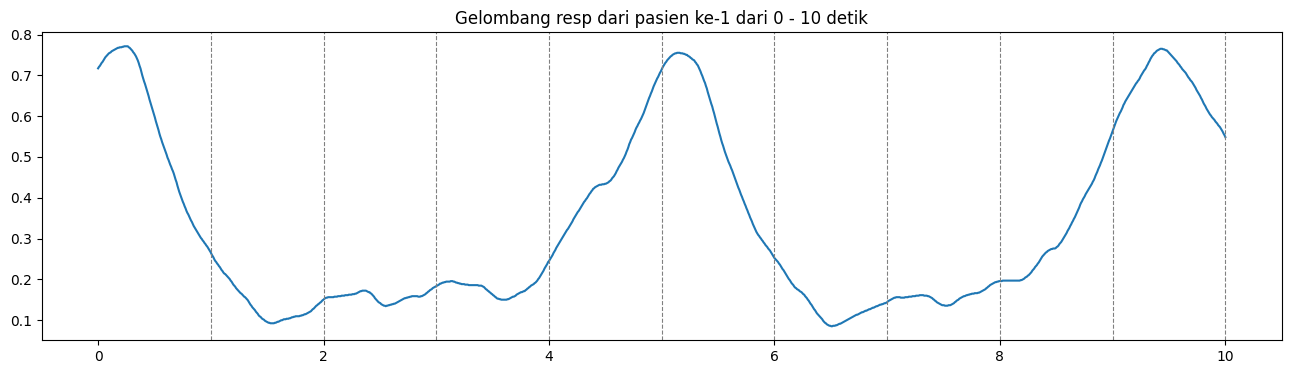

In [12]:
for i in df.columns[1:-1]:
    show_wave_from(df, fitur=i, sample_rate=125)

## AF VS Non-AF Wave

Non-AF Wave:

Feature: PPG


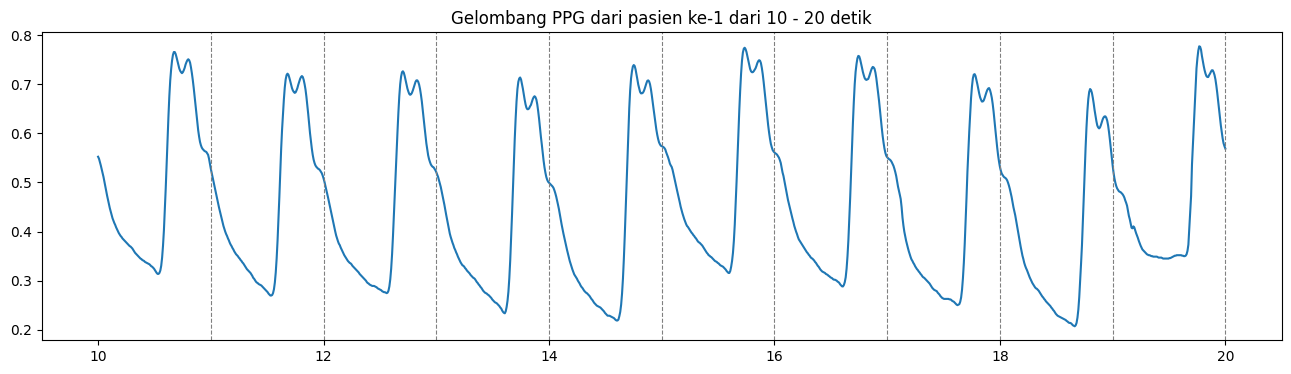


Feature: ECG


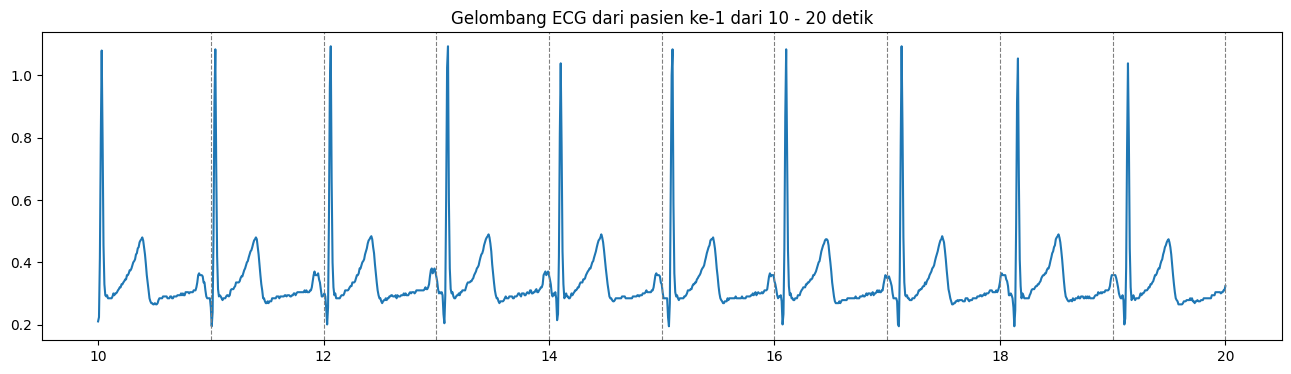


Feature: resp
  Min: 0.0910209102091021
  Max: 0.789667896678967
  Std: 0.20287974798374794
  Unique values: 441


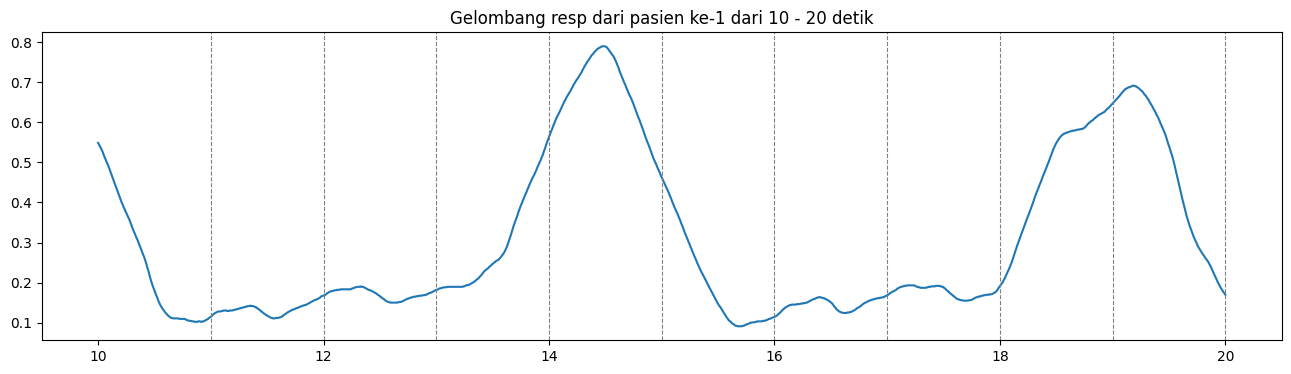


AF Wave:

Feature: PPG


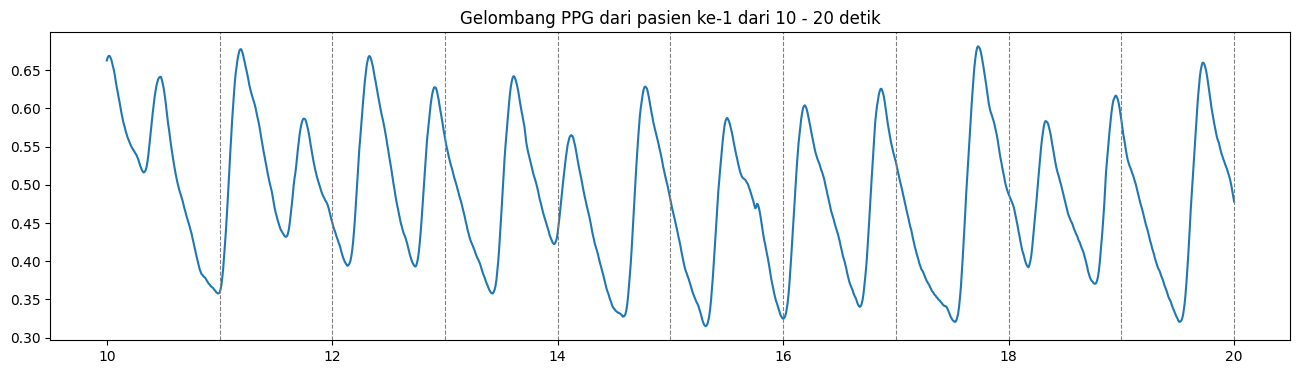


Feature: ECG


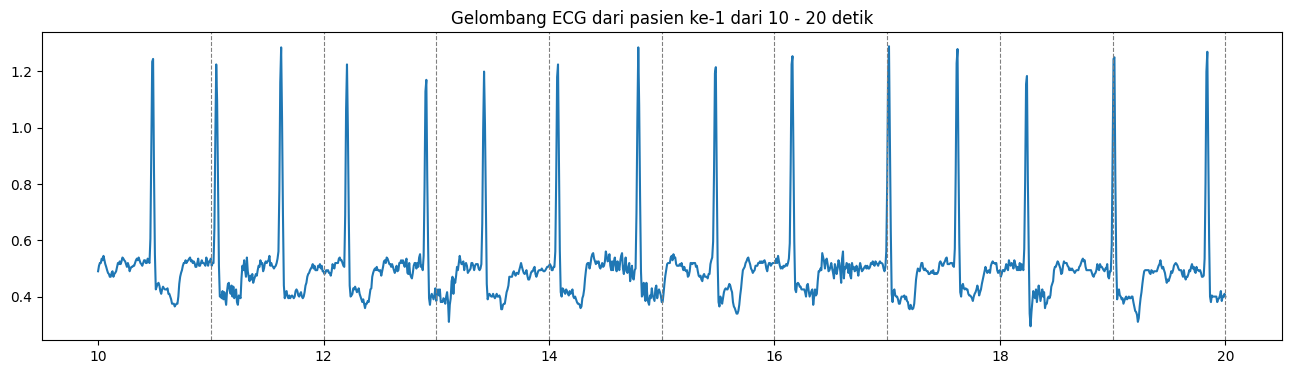


Feature: resp
  Min: -0.339853300733496
  Max: 0.493887530562347
  Std: 0.22667350914833606
  Unique values: 309


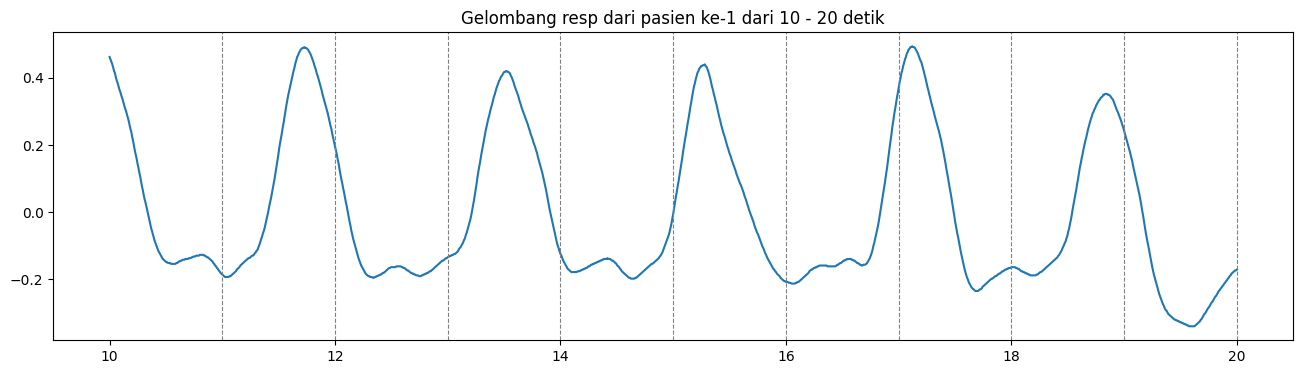

In [13]:
# Check data resp untuk pasien yang dipilih
print('Non-AF Wave:')
for i in df.columns[1:-1]:
    print(f'\nFeature: {i}')
    # Ambil data pasien pertama non-AF
    nonaf_df = df[df['status'] == 0]
    pasien_data = nonaf_df[1250:2500]  # 10-20 detik
    
    # Cek apakah ada variasi di data resp
    if i == 'resp':
        print(f"  Min: {pasien_data[i].min()}")
        print(f"  Max: {pasien_data[i].max()}")
        print(f"  Std: {pasien_data[i].std()}")
        print(f"  Unique values: {pasien_data[i].nunique()}")
    
    show_wave_from(df, sample_rate=125, pasien_ke=1, s_start=10, s_stop=20, af_status=0, fitur=i)

print('\n' + '='*50)
print('AF Wave:')
for i in df.columns[1:-1]:
    print(f'\nFeature: {i}')
    # Ambil data pasien pertama AF
    af_df = df[df['status'] == 1]
    pasien_data = af_df[1250:2500]  # 10-20 detik
    
    # Cek apakah ada variasi di data resp
    if i == 'resp':
        print(f"  Min: {pasien_data[i].min()}")
        print(f"  Max: {pasien_data[i].max()}")
        print(f"  Std: {pasien_data[i].std()}")
        print(f"  Unique values: {pasien_data[i].nunique()}")
    
    show_wave_from(df, sample_rate=125, pasien_ke=1, s_start=10, s_stop=20, af_status=1, fitur=i)

# Praprocessing

## Feature Engineering

In [14]:
train.drop(columns=['resp'], inplace=True)
test.drop(columns=['resp'], inplace=True)
val.drop(columns=['resp'], inplace=True)

## Imputation: Interpolation

In [16]:
train['PPG'] = train['PPG'].interpolate()
train['ECG'] = train['ECG'].interpolate()
# train['resp'] = train['resp'].interpolate(limit_direction='both')
train.isna().sum()

Time      0
PPG       0
ECG       0
status    0
dtype: int64

In [17]:
test['PPG'] = test['PPG'].interpolate()
test['ECG'] = test['ECG'].interpolate()
# test['resp'] = test['resp'].interpolate()
test.isna().sum()

Time      0
PPG       0
ECG       0
status    0
dtype: int64

In [18]:
val['PPG'] = val['PPG'].interpolate()
val['ECG'] = val['ECG'].interpolate()
# val['resp'] = val['resp'].interpolate()
val.isna().sum()


Time      0
PPG       0
ECG       0
status    0
dtype: int64

## Set Window Size

In [20]:
sampling_rate = 125
window_size = sampling_rate    # 125 segment per window
n_features = 2  # PPG, ECG kalau tanpa RESP
# n_features = 3  # PPG, ECG, and RESP 

def create_windows(data):
    """Create windows from signal data"""
    ppg_signal = data['PPG'].values
    ecg_signal = data['ECG'].values
    # resp_signal = data['resp'].values
    n_windows = len(ppg_signal) // window_size
    
    windows_list = []
    for i in range(n_windows):
        start = i * window_size
        end = start + window_size
        ppg_window = ppg_signal[start:end]
        ecg_window = ecg_signal[start:end]
        # resp_window = resp_signal[start:end]
        # Stack PPG, ECG, and RESP as separate features
        combined_window = np.column_stack([ppg_window, ecg_window]) # , resp_window
        windows_list.append(combined_window)
    
    # Convert to array: shape will be (n_windows, 125, 2)
    windows_array = np.array(windows_list)
    print(f"Windows shape: {windows_array.shape}")
    
    # Flatten for DataFrame storage: each row = 250 values (125*2)
    df_window = pd.DataFrame(windows_array.reshape(n_windows, -1))
    return df_window, n_windows

# Create windows for train and test separately
df_window_train, n_windows_train = create_windows(train)
df_window_test, n_windows_test = create_windows(test)
df_window_val, n_windows_val = create_windows(val)

print(f"\nTrain windows: {n_windows_train}")
print(f"Test windows: {n_windows_test}")
print(f"Validation windows: {n_windows_val}")

# Use combined df_window for compatibility with cells below
df_window = pd.concat([df_window_train, df_window_test, df_window_val], ignore_index=True)
n_windows = n_windows_train + n_windows_test + n_windows_val

print(f"\nTotal windows: {n_windows}")
df_window


Windows shape: (27600, 125, 2)
Windows shape: (7200, 125, 2)
Windows shape: (7200, 125, 2)

Train windows: 27600
Test windows: 7200
Validation windows: 7200

Total windows: 42000


,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,0.537634,0.425781,0.534702,0.404297,0.531769,0.400391,0.528837,0.400391,0.524927,0.419922,...,0.393939,0.490234,0.389052,0.509766,0.384164,0.525391,0.379277,0.535156,0.374389,0.529297
1,0.369501,0.529297,0.363636,0.525391,0.358749,0.544922,0.353861,0.519531,0.347996,0.515625,...,0.582600,0.484375,0.577713,0.470703,0.572825,0.470703,0.566960,0.480469,0.560117,0.455078
2,0.552297,0.474609,0.544477,0.494141,0.538612,0.509766,0.532747,0.515625,0.527859,0.500000,...,0.522972,0.470703,0.519062,0.480469,0.514174,0.474609,0.509286,0.460938,0.505376,0.460938
3,0.500489,0.455078,0.496579,0.449219,0.491691,0.445312,0.487781,0.445312,0.482893,0.449219,...,0.555230,0.400391,0.551320,0.404297,0.547410,0.416016,0.542522,0.464844,0.538612,0.490234
4,0.532747,0.494141,0.526882,0.470703,0.521017,0.490234,0.515152,0.519531,0.510264,0.539062,...,0.376344,0.535156,0.378299,0.529297,0.382209,0.525391,0.388074,0.519531,0.396872,0.519531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0.325513,0.589844,0.314761,0.605469,0.306940,0.583984,0.301075,0.609375,0.299120,0.599609,...,0.560117,0.580078,0.542522,0.560547,0.525904,0.589844,0.508309,0.574219,0.492669,0.605469
41996,0.479961,0.595703,0.472141,0.625000,0.467253,0.609375,0.465298,0.644531,0.464321,0.634766,...,0.318671,0.595703,0.334311,0.580078,0.353861,0.544922,0.378299,0.529297,0.408602,0.544922
41997,0.440860,0.519531,0.476051,0.544922,0.510264,0.525391,0.540567,0.539062,0.565982,0.535156,...,0.450635,0.619141,0.447703,0.609375,0.446725,0.583984,0.446725,0.574219,0.446725,0.580078
41998,0.446725,0.554688,0.444770,0.580078,0.442815,0.554688,0.438905,0.580078,0.434018,0.560547,...,0.728250,0.509766,0.722385,0.535156,0.713587,0.519531,0.702835,0.515625,0.689150,0.539062


In [21]:
# jml kolom
len(df_window.iloc[0,:])

250

### Visualisasi

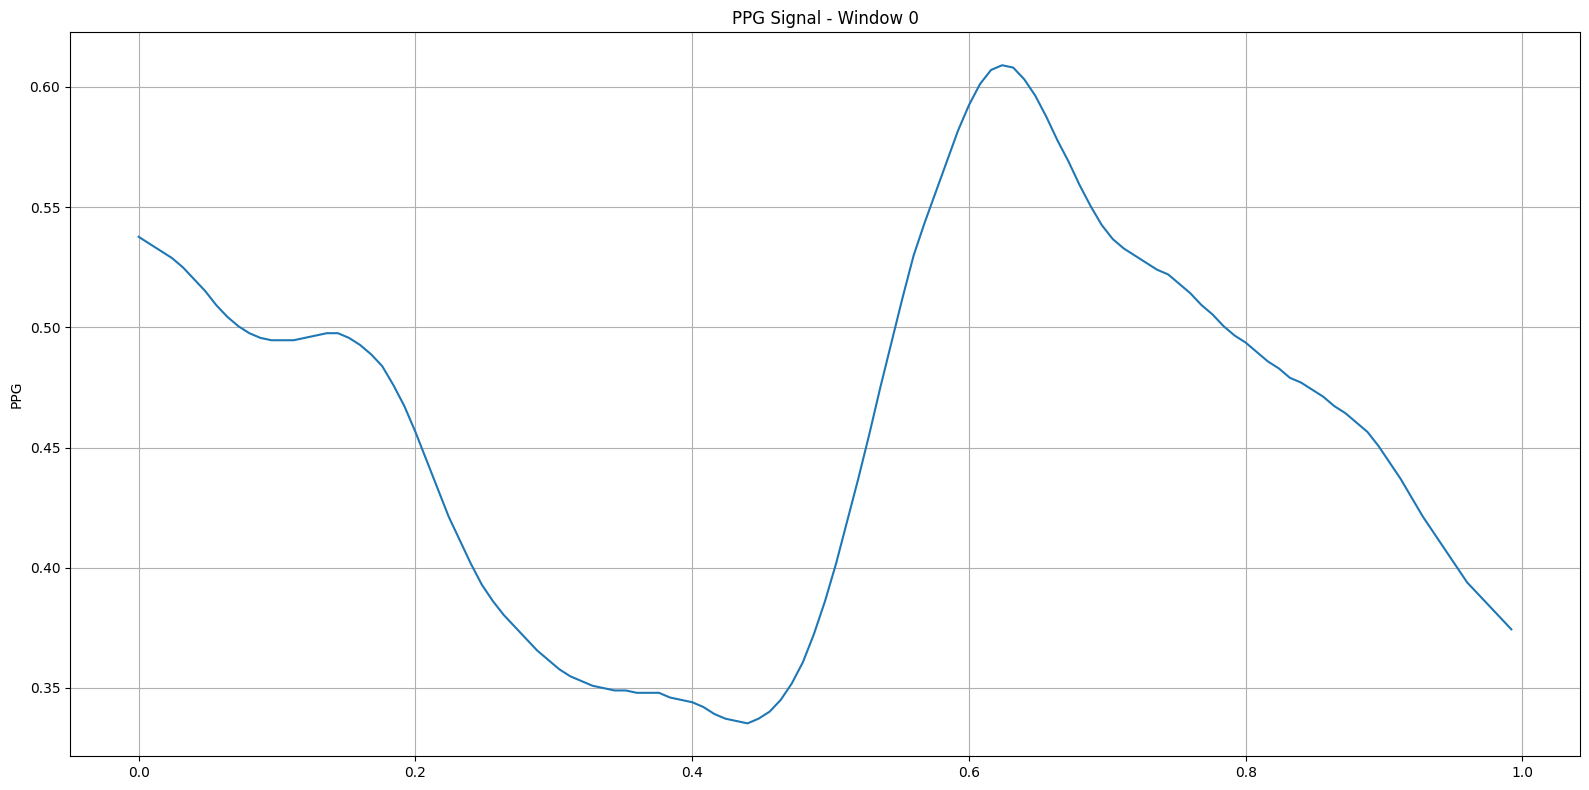

In [23]:
# Visualize one window from df_window
window_idx = 0  # Select which window to visualize
window_data = df_window_train.iloc[window_idx].values.reshape(125, n_features)

# Create time array for x-axis
time_array = np.arange(125) / sampling_rate

# Plot the three signals
plt.figure(figsize=(16, 8))

plt.plot(time_array, window_data[:, 0])
plt.title(f'PPG Signal - Window {window_idx}')
plt.ylabel('PPG')
plt.grid(True)

plt.tight_layout()
plt.show()

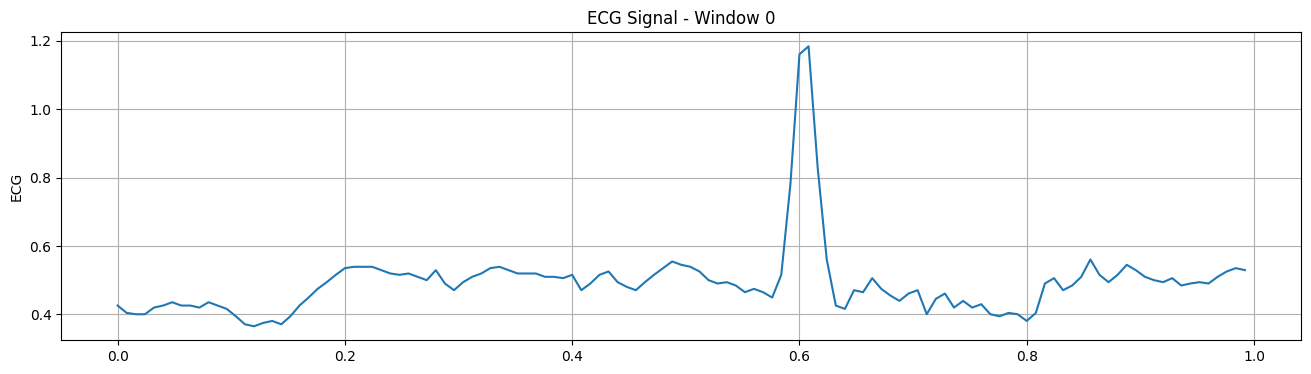

In [24]:
plt.figure(figsize=(16, 4))
plt.plot(time_array, window_data[:, 1])
plt.title(f'ECG Signal - Window {window_idx}')
plt.ylabel('ECG')
plt.grid(True)
plt.show()

In [ ]:
# plt.figure(figsize=(16, 4))
# plt.plot(time_array, window_data[:, 2])
# plt.title(f'RESP Signal - Window {window_idx}')
# plt.ylabel('RESP')
# plt.xlabel('Time (seconds)')
# plt.grid(True)
# plt.show()

## Add Label

In [27]:
train_status = train['status'].values
test_status = test['status'].values
val_status = val['status'].values

train_labels = []
for i in range(n_windows_train):
    start = i * window_size
    end = start + window_size
    window_status = train_status[start:end]
    label = mode(window_status, keepdims=False).mode
    train_labels.append(label)

test_labels = []
for i in range(n_windows_test):
    start = i * window_size
    end = start + window_size
    window_status = test_status[start:end]
    label = mode(window_status, keepdims=False).mode
    test_labels.append(label)

val_labels = []
for i in range(n_windows_val):
    start = i * window_size
    end = start + window_size
    window_status = val_status[start:end]
    label = mode(window_status, keepdims=False).mode
    val_labels.append(label)

df_label_train = pd.Series(train_labels)
df_label_test = pd.Series(test_labels)
df_label_val = pd.Series(val_labels)


df_label = pd.concat([df_label_train, df_label_test, df_label_val], ignore_index=True)

print(f"Train labels: {len(df_label_train)}")
print(f"Test labels: {len(df_label_test)}")
print(f"Validation Labels: {len(df_label_val)}")
print(f"Total labels: {len(df_label)}")
df_label

Train labels: 27600
Test labels: 7200
Validation Labels: 7200
Total labels: 42000


0        1
1        1
2        1
3        1
4        1
        ..
41995    0
41996    0
41997    0
41998    0
41999    0
Length: 42000, dtype: int64

## Preprocess Pipeline

In [29]:
# Reshape data to 3D format (n_samples, 125, 3)
# Data now has 375 columns (125 timesteps * 3 features: PPG, ECG, RESP)
X_train_prep = df_window_train.values.reshape(-1, 125, 2)
X_val_prep = df_window_val.values.reshape(-1, 125, 2)
X_test_prep = df_window_test.values.reshape(-1, 125, 2)

print(f"X_train shape: {X_train_prep.shape}")
print(f"X_val shape: {X_val_prep.shape}")
print(f"X_test shape: {X_test_prep.shape}")
print(f"\n✅ Data contains PPG and ECG (2 features)")

X_train shape: (27600, 125, 2)
X_val shape: (7200, 125, 2)
X_test shape: (7200, 125, 2)

✅ Data contains PPG and ECG (2 features)


In [30]:
# Transformer buat reshape 2D jadi 3D (updated for 3 features)
class ReshapeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_timesteps=125, n_features=3):
        self.n_timesteps = n_timesteps
        self.n_features = n_features

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # reshape jadi 3D: (n_samples, n_timesteps, n_features)
        if isinstance(X, pd.DataFrame):
            X = X.values
        return np.reshape(X, (X.shape[0], self.n_timesteps, self.n_features))

In [31]:
X_train_prep.shape

(27600, 125, 2)

# Ekstraksi Fitur

## LSTM Model untuk Ekstraksi Fitur

In [ ]:
def build_model(n_timesteps=125, n_features=2):
    """Build LSTM model for PPG, ECG signals"""
    model = Sequential([
        Input(shape=(n_timesteps, n_features)),
        LSTM(64),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'recall'])
    return model

In [33]:
# Train LSTM model
model = build_model(n_timesteps=125, n_features=2)
tf.compat.v1.enable_eager_execution()
history = model.fit(
    X_train_prep, df_label_train,
    epochs=60, # 60
    batch_size=64,
    validation_data=(X_val_prep, df_label_val),
    verbose=1
)
print(f"Training completed. Final val_loss: {history.history['val_loss'][-1]:.4f}")


Epoch 1/60
432/432 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.6234 - loss: 0.6520 - recall: 0.7451 - val_accuracy: 0.6658 - val_loss: 0.6651 - val_recall: 0.9456
Epoch 2/60
432/432 ━━━━━━━━━━━━━━━━━━━━ 35s 80ms/step - accuracy: 0.6336 - loss: 0.6410 - recall: 0.7883 - val_accuracy: 0.8467 - val_loss: 0.5120 - val_recall: 0.9633
Epoch 3/60
432/432 ━━━━━━━━━━━━━━━━━━━━ 34s 78ms/step - accuracy: 0.6869 - loss: 0.5680 - recall: 0.7167 - val_accuracy: 0.7126 - val_loss: 0.9780 - val_recall: 0.8464
Epoch 4/60
432/432 ━━━━━━━━━━━━━━━━━━━━ 34s 78ms/step - accuracy: 0.6929 - loss: 0.5517 - recall: 0.7144 - val_accuracy: 0.6851 - val_loss: 0.9926 - val_recall: 0.9858
Epoch 5/60
432/432 ━━━━━━━━━━━━━━━━━━━━ 42s 97ms/step - accuracy: 0.6723 - loss: 0.5723 - recall: 0.8162 - val_accuracy: 0.5381 - val_loss: 0.5991 - val_recall: 0.9603
Epoch 6/60
432/432 ━━━━━━━━━━━━━━━━━━━━ 50s 117ms/step - accuracy: 0.7017 - loss: 0.5534 - recall: 0.8352 - val_accuracy: 0.7038 - val_loss: 0.6036 - val_recal

In [ ]:
# Save trained LSTM model
# os.makedirs('models/SVM', exist_ok=True)
os.makedirs('models/XGBOOST', exist_ok=True)
# os.makedirs('models/RF', exist_ok=True)
timestamp = dt.now().strftime('%d%m%Y_%H%M%S')
# model_path = f'models/SVM/1d-cnn_ppg_ecg_resp_{timestamp}.h5'
# model_path = f'models/RF/1d-cnn_ppg_ecg_resp_{timestamp}.h5'
model_path = f'models/XGBOOST/lstm_ppg_ecg_resp_{timestamp}.h5'

model.save(model_path)
print(f'LSTM model saved as: {model_path}')

LSTM model saved as: models/XGBOOST/lstm_ppg_ecg_resp_04122025_232353.h5


## Load Model

In [ ]:
# # Load saved LSTM model
# model_path = r"C:\Users\Lenovo\Documents\GitHub\FP_MLxDM\models\XGBOOST\lstm_ppg_ecg_resp_04122025_224855.h5"
# model = load_model(model_path)
# print(f'✅ LSTM model loaded from: {model_path}')
# print(f'Model summary:')
# model.summary()


## Visualisasi Hasil

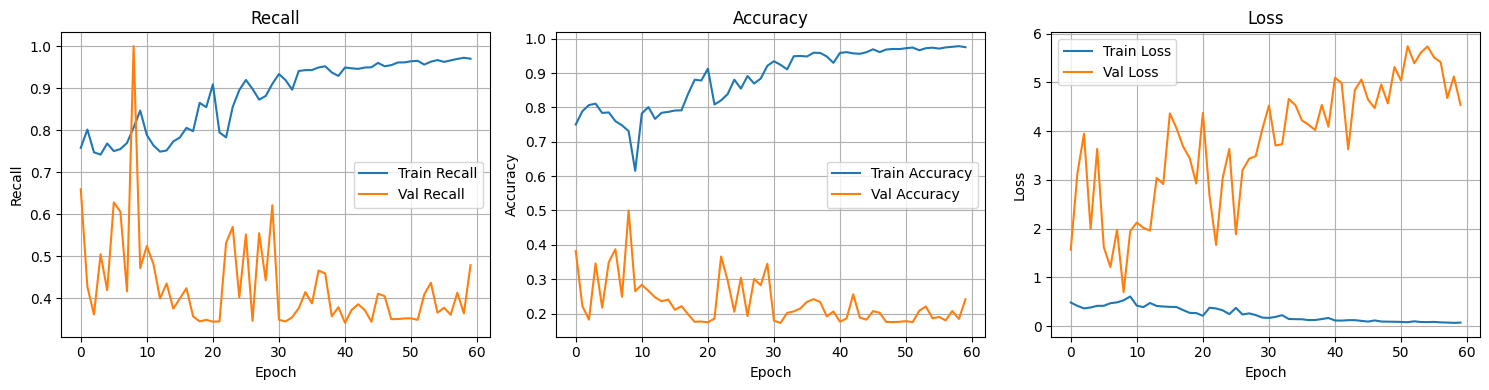

In [ ]:
# Plot training history
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Val Recall')
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Build Feature Extractor dari LSTM yang sudah dilatih
# Menggunakan output dari last dense layer (Dense 32) sebagai fitur
lstm_last_dense = Model(inputs=model.inputs, outputs=model.layers[-2].output)

print("✅ LSTM Feature Extractor created")
lstm_last_dense.summary()

✅ LSTM Feature Extractor created


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 125, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,488 (76.12 KB)

 Trainable params: 19,488 (76.12 KB)

 Non-trainable params: 0 (0.00 B)

## Ekstraksi Fitur dari LSTM

In [ ]:
# Extract features menggunakan LSTM feature extractor
# Output: 32 fitur dari last dense layer untuk setiap sampel
X_train_xtract = lstm_last_dense.predict(X_train_prep)
X_val_xtract = lstm_last_dense.predict(X_val_prep)
X_test_xtract = lstm_last_dense.predict(X_test_prep)

print(f"✅ Extracted features shape:")
print(f"   Train: {X_train_xtract.shape}")
print(f"   Val: {X_val_xtract.shape}")
print(f"   Test: {X_test_xtract.shape}")
print(f"   Features extracted from 3 physiological signals (PPG, ECG, RESP)")

863/863 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
✅ Extracted features shape:
   Train: (27600, 32)
   Val: (7200, 32)
   Test: (7200, 32)
   Features extracted from 3 physiological signals (PPG, ECG, RESP)


# Classifier

## Hyperparameter Tuning dengan Grid Search

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [7, 9, 11, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8]
}

In [ ]:
# hybrid = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=77)

# grid_search = GridSearchCV(
#     estimator=xgb,          
#     param_grid=param_grid,  
#     scoring='roc_auc',      
#     cv=3,                   
#     verbose=2,              
#     n_jobs=-1               
# )

In [ ]:
# print("Starting GridSearchCV...")
# grid_search.fit(X_train_xtract, y_train)
# print("GridSearchCV Done")

In [ ]:
# print("Parameter terbaik:", grid_search.best_params_)
# print("Skor cross-validation terbaik:", grid_search.best_score_)

# best_hybrid = grid_search.best_estimator_

## Evaluasi Model GridSearch CV

## Hyperparameter Tuning dengan Optuna

In [ ]:
# Tambah sendiri

## Evaluasi Model Optuna

In [ ]:
## Tambah sendiri

## Tanpa Hyperparameter Tuning

In [ ]:
best_hybrid = XGBClassifier()

best_hybrid.fit(X_train_xtract, df_label_train)
best_hybrid

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [ ]:
# Save trained LSTM model
# os.makedirs('models/SVM', exist_ok=True)
os.makedirs('models/XGBOOST', exist_ok=True)
# os.makedirs('models/RF', exist_ok=True)
timestamp = dt.now().strftime('%d%m%Y_%H%M%S')
# model_path = f'models/SVM/1d-cnn_ppg_ecg_resp_{timestamp}.h5'
# model_path = f'models/RF/1d-cnn_ppg_ecg_resp_{timestamp}.h5'
model_path = f'models/XGBOOST/lstm_ppg_ecg_resp_{timestamp}.h5'

model.save(model_path)
print(f'LSTM model saved as: {model_path}')

In [ ]:
y_prob_hybrid = best_hybrid.predict_proba(X_test_xtract)[:,1]
y_pred = best_hybrid.predict(X_test_xtract)
y_prob_hybrid

array([0.99993694, 0.99996865, 0.99993014, ..., 0.99990773, 0.99990773,
       0.99994445], shape=(7200,), dtype=float32)

## Evaluasi Model Tanpa Hyperparamater Tuning

In [ ]:
acc = accuracy_score(df_label_test, y_pred)
prec = precision_score(df_label_test, y_pred)
recall = recall_score(df_label_test, y_pred)
f1 = f1_score(df_label_test, y_pred)
roauc = roc_auc_score(df_label_test, y_prob_hybrid)

print('Hybrid Evaluation')
print(f'Accuracy: {acc:.4f}')
print(f"Precision: {prec:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"ROC AUC  : {roauc:.4f}")

print(classification_report(df_label_test, y_pred))

Hybrid Evaluation
Accuracy: 0.2326
Precision: 0.3152
Recall   : 0.4558
F1 Score : 0.3727
ROC AUC  : 0.1846
              precision    recall  f1-score   support

           0       0.02      0.01      0.01      3600
           1       0.32      0.46      0.37      3600

    accuracy                           0.23      7200
   macro avg       0.17      0.23      0.19      7200
weighted avg       0.17      0.23      0.19      7200



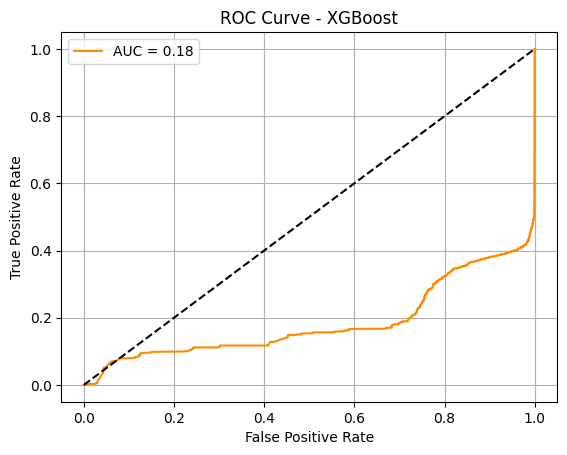

In [ ]:
fpr, tpr, _ = roc_curve(df_label_test, y_prob_hybrid)
plt.plot(fpr, tpr, label=f"AUC = {roauc:.2f}", color='darkorange')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend()
plt.grid(True)
plt.show()

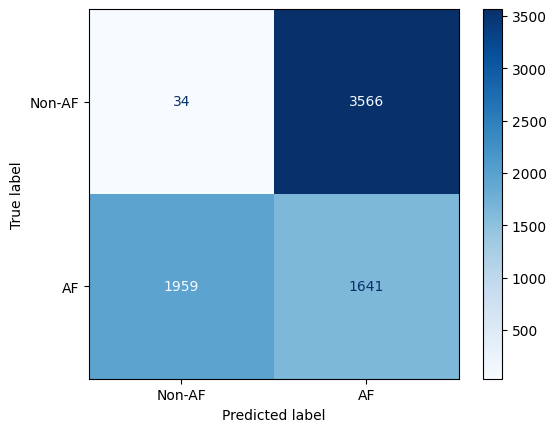

In [ ]:
# Confusion matrix hybrid
cm = confusion_matrix(df_label_test, y_pred)
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-AF', 'AF'])
disp_cm.plot(cmap='Blues')

# Evaluasi

## Histogram Perbandingan Accuracy

In [ ]:
## isi sendiri

## Histogram Perbandingan Recall

In [ ]:
## isi sendiri

# SAVE ALL

In [ ]:
# # Target directory
# os.makedirs('model_deploy', exist_ok=True)
# timestamp = dt.now().strftime('%d%m%Y_%H%M%S')

# # Preprocessing pipeline: MinMaxScaler, PCA, ReshapeTransformer (pkl)
# # path_prep = f'model_deploy/{timestamp}_preprocess.pkl'
# # joblib.dump(preprocess_pipeline, path_prep)
# # print("1. Preprocessing pipeline successfully saved.")

# # Reshaper for input LSTM (pkl)
# path_reshaper = f'model_deploy/{timestamp}_reshaper.pkl'
# joblib.dump(reshape_pipeline, path_reshaper)
# print("1. Reshaper has been successfully saved.")

# # LSTM Model for feature extraction (h5)
# path_lstx = f'model_deploy/{timestamp}_lstmx.h5'
# lstm_last_dense.save(path_lstx)
# print("2. LSTMX pipeline successfully saved.")

# # Hybrid LSTM-XGBoost (json)
# path_hybrid = f'model_deploy/{timestamp}_hybrid_lxgb.json'
# best_hybrid.save_model(path_hybrid)
# print("3. Hybrid model successfully saved.")

<!-- # Contoh cara pake buat prediksi -->

In [ ]:
# # --- Load semua komponen ---
# loaded_preprocessor = joblib.load(path_prep)
# loaded_feature_extractor = tf.keras.models.load_model(path_lstx)
# loaded_xgb_model = XGBClassifier()
# loaded_xgb_model.load_model(path_hybrid)


# # --- Buat fungsi prediksi end-to-end ---
# def predict_hybrid_system(data_mentah):
#     """
#     Fungsi ini menjalankan data mentah melalui seluruh alur hybrid.
#     """
#     # Pastikan input adalah 2D
#     if data_mentah.ndim == 1:
#         data_mentah = data_mentah.reshape(1, -1)
        
#     # 1. Jalankan preprocessing
#     data_processed = loaded_preprocessor.transform(data_mentah)
    
#     # 2. Ekstrak fitur dengan LSTM
#     fitur_lstm = loaded_feature_extractor.predict(data_processed)
    
#     # 3. Lakukan prediksi akhir dengan XGBoost
#     prediksi_final = loaded_xgb_model.predict(fitur_lstm)
#     probabilitas = loaded_xgb_model.predict_proba(fitur_lstm)
    
#     return prediksi_final[0], probabilitas[0]


# # --- Uji coba pada satu sampel data mentah ---
# # Ambil satu sampel dari X_test MENTAH (sebelum diproses)
# contoh_data = X_test_mentah[0] 

# hasil, prob = predict_hybrid_system(contoh_data)

# print(f"\n--- Hasil Prediksi pada Data Baru ---")
# print(f"Prediksi Kelas: {hasil} (0=Non-AF, 1=AF)")
# print(f"Probabilitas [Non-AF, AF]: [{prob[0]:.4f}, {prob[1]:.4f}]")